# Kaggle-CSGO: round winner prediction
Aquest dataset conté informació sobre diferents partides del joc CS:GO (Counter Strike Global Offensive). Es tracta d'un joc first-person shooter desenvolupat per Valve.
El joc consisteix en que l'equip T (Terrorist) ha de fer explotar una bomba i l'equip CT (Counter Terrorists) ha d'evitar-ho.

L'objectiu d'aquest exercici és classificar quin equip guanyarà una ronda a partir d'atributs com són la vida dels equips, els diners, el mapa, les armes o si la bomba ha estat activada.

Primer, carreguem el dataset que es troba a la carpeta data utilitzant la llibreria pandas:

In [18]:
import pandas as pd
import numpy as np
import random
import time
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


sns.set(rc={'figure.figsize':(11.7,8.27)})

def load_dataset(path):
    df = pd.read_csv(path, delimiter=',', engine='python')
    return df

dataset = load_dataset('../data/csgo_round_snapshots.csv')
# Veiem les dimensionalitats de la base de dades i les 5 primeres files, per veure el format.
print("Dimensionalitat de la BBDD: ", dataset.shape)
dataset.head()

Dimensionalitat de la BBDD:  (122410, 97)


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


Podem veure que es tracta d'una base de dades de 122410 files i 97 columnes.

# Data understanding
En aquest aparatat veurem la distribució d'alguns atributs com l'equip que guanya o els diferents mapes.

Text(0.5, 1.0, 'Quantitat de partides guanaydes per equip')

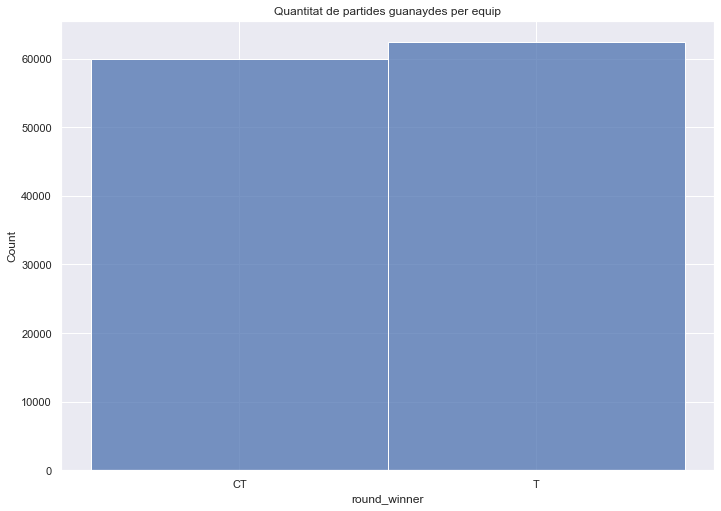

In [19]:
# Per veure la distibució de qui guanya més partides
sns.histplot(data=dataset, x='round_winner').set_title('Quantitat de partides guanaydes per equip')

Podem veure que el nostre datasaet conté més mostres on l'equip T guanya.

Text(0.5, 1.0, 'Distribució dels mapes')

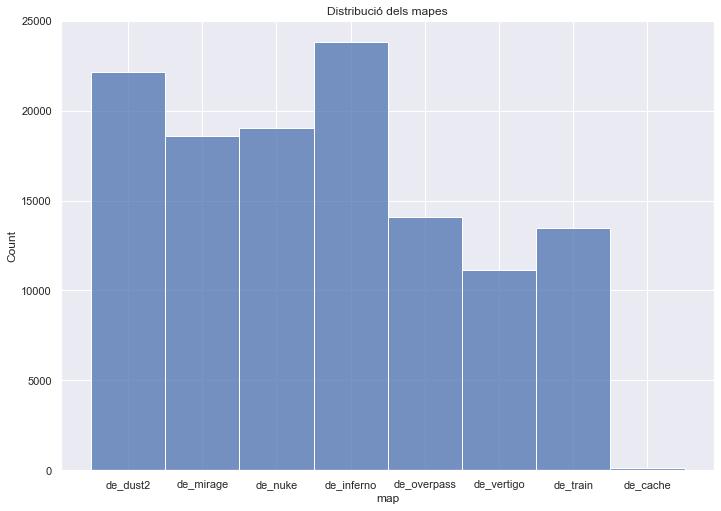

In [20]:
# Per veure la distribució dels mapes
sns.histplot(data = dataset, x = 'map').set_title('Distribució dels mapes')

Podem veure que els dos mapes dels que tenim més informació son dust2 i inferno. 
Ara mirem com és la distribució de l'equip que guanya la ronda en aquest dos mapes.

<AxesSubplot:xlabel='round_winner', ylabel='Count'>

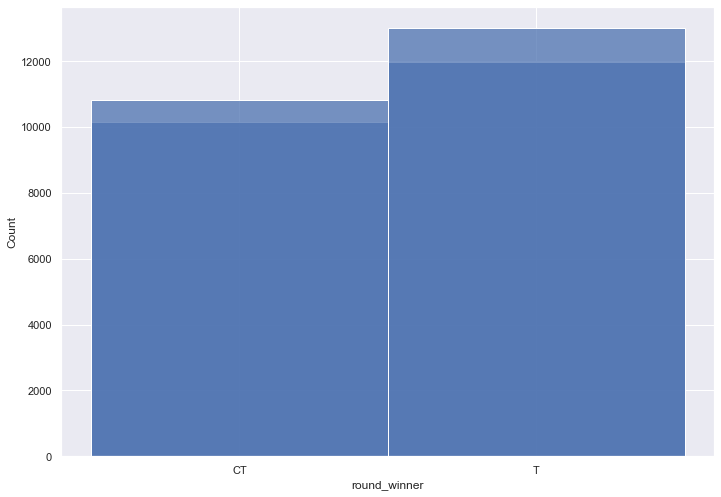

In [21]:
d1 = dataset[dataset['map'] == 'de_dust2']
d2 = dataset[dataset['map'] == 'de_inferno']
# dust2
sns.histplot(data=d1, x='round_winner')
# inferno
sns.histplot(data=d2, x='round_winner')

Podem veure com la distribució de els equips que guanyen manté la relació en els dos mapes (dust més fosc i inferno més clar) sent T l'equip que més rondes guanya

Un altre atribut important en aquest tipus de joc són els diners que té cada equip en una ronda, això determina les armes o l'armadura que podran comprar. Quant més diners té un equip, més probable és de que guanyi la ronda.

In [22]:
row = random.randint(0, dataset.shape[0])
sample = dataset.iloc[[row]]
ct_money, t_money = sample['ct_money'], sample['t_money']
print('ct_money: ', ct_money)
print('t_money: ', t_money)

ct_money:  114412    700.0
Name: ct_money, dtype: float64
t_money:  114412    600.0
Name: t_money, dtype: float64


# Data cleaning
Com es tracta d'una base de dades sobre un videojoc on l'informació sobre la vida, diners o les armes que s'utilitzen en una partida és important, no podem eliminar ni sustituir aquells atributs que tenen "0.0", és a dir missing values.

Si sustituim els missing values d'un atribut per la mitjana d'aquest atribut, estariem alterant aquella partida. Per exemple, si en una mostra, cap jugador utilitza una determinada arma i nosaltres modifiquem aquell valor per la mitjana, estem indicant que l’arma si ha estat utilitzada, això pot provocar que la clssificacio no sigui precisa. El mateix passaría si modifiquem els diners en una ronda inicial, l'armadura o la puntuació.

Per tenir tots els atributs en el mateix format, aplico un processament de dades binaries i categòriques

In [23]:
encoder = LabelEncoder()
scaler = StandardScaler()
# Eliminació de columnes amb un únic valor
for column in dataset.columns:
    if len(dataset[column].unique()) == 1:
        dataset = dataset.drop([column], axis=1)
        
# Sustituio l'equip guanyador per 0 (T) i 1 (CT) 
# Passo la columna bomb_planted de tipus booleà a tipus int
dataset['round_winner'] = dataset['round_winner'].replace({'T' : 0, 'CT' : 1})
dataset['bomb_planted'] = dataset['bomb_planted'].astype(np.int16)
y = dataset['round_winner']

# Eliminem la columna objectiu per reduïr el dataset
dataset = dataset.drop('round_winner', axis = 1)
dataset['map'] = encoder.fit_transform(dataset['map'])



# Implementation
Per a la implementació d'aquest exercici faré diferents models de classificació per aixó comparar-los després

Dividim el dataset en conjunt de dades d'entrenament i test:

In [24]:
X = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Logistic Regression
En aquest cas utilitzo una optimització vista a la documentació de Kaggle utilitzant GridSearchCV. Aplica cross validation

In [25]:
start1 = time.time()
LR = LogisticRegression(max_iter=1000)
param_grid1 = {'fit_intercept':[True,False], 'C': [10, 100]}
# Utilitzo aquest optimitzador, vist a la documentació de Kaggle
Optimizer1 = GridSearchCV(LR, param_grid1, cv=5)
Optimizer1.fit(X_train, y_train)

predsTrain1 = Optimizer1.predict(X_train)
predsTest1 = Optimizer1.predict(X_test)

In [26]:
# Train
print(classification_report(y_train, predsTrain1))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     41793
           1       0.74      0.76      0.75     40221

    accuracy                           0.75     82014
   macro avg       0.75      0.75      0.75     82014
weighted avg       0.75      0.75      0.75     82014



In [27]:
# Test
print(classification_report(y_test, predsTest1))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     20613
           1       0.74      0.76      0.75     19783

    accuracy                           0.75     40396
   macro avg       0.75      0.75      0.75     40396
weighted avg       0.75      0.75      0.75     40396



In [28]:
end1 = time.time()
print("Time LR: ", end1-start1)

Time LR:  51.51911187171936


# Decision Tree
En aquest cas utilitzo una optimització vista a la documentació de Kaggle utilitzant GridSearchCV. Aplica cross validation

In [29]:
start2 = time.time()
DT = DecisionTreeClassifier()
param_grid2 = {'max_depth':[None,1,2,3], 'min_samples_leaf' :[2,3,4]}

# Utilitzo aquest optimitzador, vist a la documentació de Kaggle
Optimizer2 = GridSearchCV(DT, param_grid2, cv = 5)
Optimizer2.fit(X_train, y_train)

predsTrain2 = Optimizer2.predict(X_train)
predsTest2 = Optimizer2.predict(X_test)

In [30]:
# Train
print(classification_report(y_train, predsTrain2))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     41793
           1       0.96      0.95      0.95     40221

    accuracy                           0.95     82014
   macro avg       0.95      0.95      0.95     82014
weighted avg       0.95      0.95      0.95     82014



In [31]:
# Test
print(classification_report(y_test, predsTest2))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     20613
           1       0.80      0.79      0.79     19783

    accuracy                           0.80     40396
   macro avg       0.80      0.80      0.80     40396
weighted avg       0.80      0.80      0.80     40396



In [32]:
end2 = time.time()
print("Time DT: ", end2-start2)

Time DT:  34.91352725028992


# KNN
En aquest cas no he aconseguit fer anar aquest model amb el GridSearchCV.

In [33]:
# KNN
start3 = time.time()
acc, t_acc = [], 0
prec, t_prec = [], 0
rec, t_rec = [], 0
n = [5, 6, 7, 8]
for i in n:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    acc.append(accuracy_score(y_test, predictions))
    prec.append(precision_score(y_test, predictions, average='micro'))
    rec.append(recall_score(y_test, predictions, average='micro'))

for i in range(0, len(n)):
    t_acc += acc[i]
    t_prec += prec[i]
    t_rec += rec[i]

print('KNN:')
print('Mean Accuracy: ', t_acc / len(n))
print('Mean Precision: ', t_prec / len(n))
print('Mean Recall: ', t_rec / len(n))

KNN:
Mean Accuracy:  0.8087248737498762
Mean Precision:  0.8087248737498762
Mean Recall:  0.8087248737498762


In [34]:
end3 = time.time()
print("Time KNN: ", end3-start3)

Time KNN:  310.03594493865967


## Conclusions

Com podem veure per les mètriques obtingudes, els millors resultats els obtenim amb el model de DecisionTree seguit del KNN i LogisticRegressor, amb accuracy de 81%, 80% i 75% respectivament.
Tot i aquest resultats, els temps d'execució són massa alts. Això és degut a que en els models de LogisticRegressor i de DecisionTree s'està aplicant un cross validation amb cv = 5, per això en cada execució realment s'està executant el model 5 cops. 
En quant al temps del KNN, crec que és degut a l'escalada de dades necessaria per als altres dos models.
A més d'això cal tenir en compte les dimensions del nostre dataset, ya que conté moltes mostres amb molts atributs que provocan que els models facin els càlculs més lentament.
Crec que per a un treball futur podria ser interessant treballar sense aquest escalament per veure una comparació.